### Student Information
Name: 楊添貴

Student ID:110006211

GitHub ID:132459662

Kaggle name:Jason Jonarto

Kaggle private scoreboard snapshot:
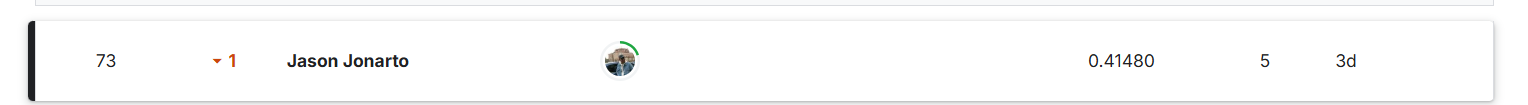

---

### Instructions

1. First: __This part is worth 30% of your grade.__ Do the **take home exercises** in the [DM2024-Lab2-master Repo](https://github.com/didiersalazar/DM2024-Lab2-Master). You may need to copy some cells from the Lab notebook to this notebook. 


2. Second: __This part is worth 30% of your grade.__ Participate in the in-class [Kaggle Competition](https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework) regarding Emotion Recognition on Twitter by this link: https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework. The scoring will be given according to your place in the Private Leaderboard ranking: 
    - **Bottom 40%**: Get 20% of the 30% available for this section.

    - **Top 41% - 100%**: Get (0.6N + 1 - x) / (0.6N) * 10 + 20 points, where N is the total number of participants, and x is your rank. (ie. If there are 100 participants and you rank 3rd your score will be (0.6 * 100 + 1 - 3) / (0.6 * 100) * 10 + 20 = 29.67% out of 30%.)   
    Submit your last submission **BEFORE the deadline (Nov. 26th, 11:59 pm, Tuesday)**. Make sure to take a screenshot of your position at the end of the competition and store it as '''pic0.png''' under the **img** folder of this repository and rerun the cell **Student Information**.
    

3. Third: __This part is worth 30% of your grade.__ A report of your work developing the model for the competition (You can use code and comment on it). This report should include what your preprocessing steps, the feature engineering steps and an explanation of your model. You can also mention different things you tried and insights you gained. 


4. Fourth: __This part is worth 10% of your grade.__ It's hard for us to follow if your code is messy :'(, so please **tidy up your notebook**.


Upload your files to your repository then submit the link to it on the corresponding e-learn assignment.

Make sure to commit and save your changes to your repository __BEFORE the deadline (Nov. 26th, 11:59 pm, Tuesday)__. 

In [4]:
### Begin Assignment Here

In [1]:
import pandas as pd
import numpy as np
import json
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Load data

In [2]:
# Load the JSON file
tweets = []
with open("tweets_DM.json", "r") as file:
    for line in file:
        tweets.append(json.loads(line))
tweets_df = pd.json_normalize(tweets)

In [3]:
emotion = pd.read_csv('emotion.csv')
data_identification = pd.read_csv('data_identification.csv')

In [4]:
tweets_df

,_score,_index,_crawldate,_type,_source.tweet.hashtags,_source.tweet.tweet_id,_source.tweet.text
0,391,hashtag_tweets,2015-05-23 11:42:47,tweets,[Snapchat],0x376b20,"People who post ""add me on #Snapchat"" must be ..."
1,433,hashtag_tweets,2016-01-28 04:52:09,tweets,"[freepress, TrumpLegacy, CNN]",0x2d5350,"@brianklaas As we see, Trump is dangerous to #..."
2,232,hashtag_tweets,2017-12-25 04:39:20,tweets,[bibleverse],0x28b412,"Confident of your obedience, I write to you, k..."
3,376,hashtag_tweets,2016-01-24 23:53:05,tweets,[],0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>
4,989,hashtag_tweets,2016-01-08 17:18:59,tweets,[],0x2de201,"""Trust is not the same as faith. A friend is s..."
...,...,...,...,...,...,...,...
1867530,827,hashtag_tweets,2015-05-12 12:51:52,tweets,"[mixedfeeling, butimTHATperson]",0x316b80,When you buy the last 2 tickets remaining for ...
1867531,368,hashtag_tweets,2017-10-02 17:54:04,tweets,[],0x29d0cb,I swear all this hard work gone pay off one da...
1867532,498,hashtag_tweets,2016-10-10 11:04:32,tweets,[],0x2a6a4f,@Parcel2Go no card left when I wasn't in so I ...
1867533,840,hashtag_tweets,2016-09-02 14:25:06,tweets,[],0x24faed,"Ah, corporate life, where you can date <LH> us..."


In [5]:
emotion

,tweet_id,emotion
0,0x3140b1,sadness
1,0x368b73,disgust
2,0x296183,anticipation
3,0x2bd6e1,joy
4,0x2ee1dd,anticipation
...,...,...
1455558,0x38dba0,joy
1455559,0x300ea2,joy
1455560,0x360b99,fear
1455561,0x22eecf,joy


In [6]:
data_identification

,tweet_id,identification
0,0x28cc61,test
1,0x29e452,train
2,0x2b3819,train
3,0x2db41f,test
4,0x2a2acc,train
...,...,...
1867530,0x227e25,train
1867531,0x293813,train
1867532,0x1e1a7e,train
1867533,0x2156a5,train


In [9]:
# Ensure column names are clean
tweets_df.columns = tweets_df.columns.str.strip()
emotion.columns = emotion.columns.str.strip()
data_identification.columns = data_identification.columns.str.strip()

# Rename columns if necessary
tweets_df.rename(columns={'_source.tweet.tweet_id': 'tweet_id'}, inplace=True)

# Retry the merge
data = pd.merge(tweets_df, emotion, how="left", on="tweet_id")
data = pd.merge(data, data_identification, how="left", on="tweet_id")

# Rename columns for consistency
data = data.rename(columns={
    "_score": "relevance_score",
    "_index": "source_index",
    "_crawldate": "crawl_date",
    "_type": "source_type",
    "_source.tweet.hashtags": "hashtags",
    "_source.tweet.text": "text",
    "tweet_id": "tweet_id",
    "emotion": "emotion",
    "identification": "data_split"  # train/test split
})

print(data.head())


   relevance_score    source_index           crawl_date source_type  \
0              391  hashtag_tweets  2015-05-23 11:42:47      tweets   
1              433  hashtag_tweets  2016-01-28 04:52:09      tweets   
2              232  hashtag_tweets  2017-12-25 04:39:20      tweets   
3              376  hashtag_tweets  2016-01-24 23:53:05      tweets   
4              989  hashtag_tweets  2016-01-08 17:18:59      tweets   

                        hashtags  tweet_id  \
0                     [Snapchat]  0x376b20   
1  [freepress, TrumpLegacy, CNN]  0x2d5350   
2                   [bibleverse]  0x28b412   
3                             []  0x1cd5b0   
4                             []  0x2de201   

                                                text       emotion data_split  
0  People who post "add me on #Snapchat" must be ...  anticipation      train  
1  @brianklaas As we see, Trump is dangerous to #...       sadness      train  
2  Confident of your obedience, I write to you, k...    

# Preprocess

In [11]:
# import re
# from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer
# import nltk

# # Download NLTK data
# nltk.download('stopwords')
# nltk.download('wordnet')


# # Initialize stopwords and lemmatizer
# stop_words = set(stopwords.words('english'))
# lemmatizer = WordNetLemmatizer()

# # Define text preprocessing function
# def preprocess_text(text):
#     # Convert to lowercase
#     text = text.lower()
#     # Remove hashtags, mentions, URLs
#     text = re.sub(r"#\w+", "", text)
#     text = re.sub(r"@\w+", "", text)
#     text = re.sub(r"http\S+|www\S+", "", text)
#     # Remove special characters and digits
#     text = re.sub(r"[^\w\s]", "", text)
#     # Replace <LH>
#     text = text.replace("<lh>", "")
#     # Remove stopwords
#     text = " ".join(word for word in text.split() if word not in stop_words)
#     # Lemmatize words
#     text = " ".join(lemmatizer.lemmatize(word) for word in text.split())
#     return text.strip()

# # Apply preprocessing
# data["clean_text"] = data["text"].apply(preprocess_text)

# # Check the cleaned data
# print(data[["text", "clean_text"]].head())


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JASON\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\JASON\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                                text  \
0  People who post "add me on #Snapchat" must be ...   
1  @brianklaas As we see, Trump is dangerous to #...   
2  Confident of your obedience, I write to you, k...   
3                Now ISSA is stalking Tasha 😂😂😂 <LH>   
4  "Trust is not the same as faith. A friend is s...   

                                          clean_text  
0   people post add must dehydrated cuz man thats lh  
1             see trump dangerous around world lh lh  
2  confident obedience write knowing even ask phi...  
3                             issa stalking tasha lh  
4  trust faith friend someone trust putting faith...  


# Split train and test

In [13]:
# Separate training and testing data
train_data = data[data["data_split"] == "train"]
test_data = data[data["data_split"] == "test"]

# Features and labels
X_train = train_data["clean_text"]
y_train = train_data["emotion"]

X_test = test_data["clean_text"]
y_test = test_data["emotion"]

# Split training data into 80% training and 20% validation
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Train Model

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorize the text data
vectorizer = TfidfVectorizer(
    max_features=235020,  # Allow more terms
    ngram_range=(1, 3),  # Unigrams, bigrams, and trigrams
    min_df=1,
    max_df=0.5,  # Exclude overly frequent terms
    sublinear_tf=True
)

X_train_tfidf = vectorizer.fit_transform(X_train_split)
X_val_tfidf = vectorizer.transform(X_val_split)
X_test_tfidf = vectorizer.transform(X_test)


In [16]:
from sklearn.naive_bayes import MultinomialNB

nb_classifier = MultinomialNB(alpha=0.5)  # Adjust alpha value
nb_classifier.fit(X_train_tfidf, y_train_split)


MultinomialNB(alpha=0.5)

# Predict

In [17]:
# Evaluate on validation set
y_val_pred = nb_classifier.predict(X_val_tfidf)
print("Validation Classification Report:")
print(classification_report(y_val_split, y_val_pred))
print("Validation Accuracy:", accuracy_score(y_val_split, y_val_pred))

# Predict on the test set
y_test_pred = nb_classifier.predict(X_test_tfidf)

# Evaluate on test set (if ground truth is available)
if y_test is not None and not y_test.isnull().all():
    print("Test Classification Report:")
    print(classification_report(y_test, y_test_pred))
    print("Test Accuracy:", accuracy_score(y_test, y_test_pred))


Validation Classification Report:
              precision    recall  f1-score   support

       anger       0.90      0.10      0.17      7973
anticipation       0.60      0.47      0.53     49787
     disgust       0.38      0.29      0.33     27820
        fear       0.74      0.25      0.37     12800
         joy       0.50      0.81      0.61    103204
     sadness       0.40      0.41      0.40     38687
    surprise       0.88      0.11      0.19      9746
       trust       0.51      0.22      0.30     41096

    accuracy                           0.50    291113
   macro avg       0.62      0.33      0.36    291113
weighted avg       0.53      0.50      0.46    291113

Validation Accuracy: 0.49630899341492823


# Submission  File

In [18]:
# Save predictions to a CSV file
test_data["predicted_emotion"] = y_test_pred
submission = test_data[["tweet_id", "predicted_emotion"]]
submission.columns = ["id", "emotion"]  # Rename columns as per submission format
submission.to_csv("submission.csv", index=False)

print("Predictions saved to submission.csv")


C:\Users\JASON\AppData\Local\Temp\ipykernel_22084\610707884.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["predicted_emotion"] = y_test_pred


Predictions saved to submission.csv
